# Evaluating Customer Service through Sentiment Analysis:

# Main goals:

1. Determine the top companies that received more disputes.
2. Is the trend of disputes increasing or decreasing?
3. What is the overall sentiment of the issues?
4. What is the sentiment for the top organizations that have disputes with regards to the issues declared by the customer


## Install required libraries

In [2]:
!pip install nltk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 16.9 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 802.0/802.0 kB 17.9 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [nltk]1/2 [nltk]


In [6]:
!pip install wordcloud

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 537.2/537.2 kB 12.7 MB/s  0:00:00


In [9]:
!pip install plotly

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 23.6 MB/s  0:00:00 eta 0:00:01


## Import Libraries

In [26]:
import numpy as np 
import pandas as pd 
import sqlite3
from collections import Counter
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

# Plotly libraries
import plotly.tools as tls
# import plotly.plotly as py # replaced by plotly / express
import plotly.graph_objects as go
import plotly.express as px

import plotly.figure_factory as ff
#import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

from plotly.subplots import make_subplots

# import os
# print(os.listdir("./"))

# Any results you write to the current directory are saved as output.

In [15]:
df = pd.read_csv("./consumer_complaints.csv", low_memory=False)
df.head()

,date_received,product,sub_product,issue,sub_issue,consumer_complaint_narrative,company_public_response,company,state,zipcode,tags,consumer_consent_provided,submitted_via,date_sent_to_company,company_response_to_consumer,timely_response,consumer_disputed?,complaint_id
0,08/30/2013,Mortgage,Other mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,U.S. Bancorp,CA,95993,NaN,NaN,Referral,09/03/2013,Closed with explanation,Yes,Yes,511074
1,08/30/2013,Mortgage,Other mortgage,"Loan servicing, payments, escrow account",NaN,NaN,NaN,Wells Fargo & Company,CA,91104,NaN,NaN,Referral,09/03/2013,Closed with explanation,Yes,Yes,511080
2,08/30/2013,Credit reporting,NaN,Incorrect information on credit report,Account status,NaN,NaN,Wells Fargo & Company,NY,11764,NaN,NaN,Postal mail,09/18/2013,Closed with explanation,Yes,No,510473
3,08/30/2013,Student loan,Non-federal student loan,Repaying your loan,Repaying your loan,NaN,NaN,"Navient Solutions, Inc.",MD,21402,NaN,NaN,Email,08/30/2013,Closed with explanation,Yes,Yes,510326
4,08/30/2013,Debt collection,Credit card,False statements or representation,Attempted to collect wrong amount,NaN,NaN,Resurgent Capital Services L.P.,GA,30106,NaN,NaN,Web,08/30/2013,Closed with explanation,Yes,Yes,511067


In [22]:
submitted_via_counts = round(df['submitted_via'].value_counts() / df.shape[0] * 100)
submitted_via_counts

submitted_via
Web            65.0
Referral       20.0
Phone           7.0
Postal mail     7.0
Fax             1.0
Email           0.0
Name: count, dtype: float64

In [17]:
df['company_response_to_consumer'].unique()

array(['Closed with explanation', 'Closed with monetary relief',
       'Closed with non-monetary relief', 'Closed', 'Untimely response',
       'In progress', 'Closed without relief', 'Closed with relief'],
      dtype=object)

In [27]:
p_product_discussions = round(df["product"].value_counts() / len(df["product"]) * 100,2)

print(p_product_discussions)


labels = list(p_product_discussions.index)
values = p_product_discussions.values.tolist()
colors = ['#F78181', '#F5A9BC', '#2E9AFE', '#58FA58', '#FAAC58', '#088A85', '#8A0808', '#848484', '#F781F3', '#D7DF01', '#2E2EFE']


product_pie = go.Pie(labels=labels, values=values, 
                          marker=dict(colors=colors,
                         line=dict(color='#000000', width=2)))

layout = go.Layout(title='Product Types')

fig = go.Figure(data=[product_pie], layout=layout)
iplot(fig)

product
Mortgage                   33.54
Debt collection            18.18
Credit reporting           16.52
Credit card                11.96
Bank account or service    11.25
Consumer Loan               3.78
Student loan                2.85
Payday loan                 0.70
Money transfers             0.69
Prepaid card                0.44
Other financial service     0.10
Name: count, dtype: float64


In [28]:
df['company_response_to_consumer'].value_counts()

company_response_to_consumer
Closed with explanation            404293
Closed with non-monetary relief     70237
Closed with monetary relief         38262
Closed without relief               17909
Closed                              13399
Closed with relief                   5305
In progress                          3763
Untimely response                    2789
Name: count, dtype: int64

In [29]:
# Building the variables for our graphs
disputed = df['consumer_disputed?'].value_counts()
company_response = df['company_response_to_consumer'].value_counts()
top5_disputed = df['company'].loc[df['consumer_disputed?'] == 'Yes'].value_counts()[:5]
top5_nodispute = df['company'].loc[df['consumer_disputed?'] == 'No'].value_counts()[:5]

In [47]:
(df[(df['consumer_disputed?'] == 'Yes') & (df['company'] == 'Bank of America')])[['company', 'consumer_disputed?']]


,company,consumer_disputed?
20,Bank of America,Yes
86,Bank of America,Yes
117,Bank of America,Yes
181,Bank of America,Yes
226,Bank of America,Yes
...,...,...
555561,Bank of America,Yes
555600,Bank of America,Yes
555687,Bank of America,Yes
555694,Bank of America,Yes


In [51]:
#FIXME: Quick fix
import plotly.graph_objects as go
from plotly.subplots import make_subplots  # modern import

# Top three subplots
total_complaints_plotly = go.Bar(
            x=disputed.index.values,
            y=disputed.values,
    text = 'Complaints',
    showlegend=False,
    marker=dict(
        color=['#40FF00', '#FF0000'])
    )

top5_disputes_plotly = go.Bar(
            x=top5_disputed.index.values,
            y=top5_disputed.values,
    text='Disputes',
    showlegend=False,
    marker=dict(
        color=top5_disputed.values,
        colorscale='Reds')
    )

top5_nodisputes_plotly = go.Bar(
            x=top5_nodispute.index.values,
            y=top5_nodispute.values,
    text='No Disputes',
    showlegend=False,
    marker=dict(
        color=top5_nodispute.values,
        colorscale='Blues')
    )

# Lower Subplot
customer_res_plotly = go.Bar(
            x=company_response.index.values,
            y=company_response.values,
    text='Customer Response',
    showlegend=False,
        marker=dict(
        color=df['company_response_to_consumer'].value_counts().values,
        colorscale = [[0.0, 'rgb(165,0,38)'], [0.1111111111111111, 'rgb(215,48,39)'], [0.2222222222222222, 'rgb(244,109,67)'], 
                      [0.3333333333333333, 'rgb(253,174,97)'], [0.4444444444444444, 'rgb(254,224,144)'], 
                      [0.5555555555555556, 'rgb(224,243,248)'], [0.6666666666666666, 'rgb(171,217,233)'], 
                      [0.7777777777777778, 'rgb(116,173,209)'], [0.8888888888888888, 'rgb(69,117,180)'], 
                      [1.0, 'rgb(49,54,149)']],
        reversescale = True
        )
)

# fig = tls.make_subplots(
#     rows=2, 
#     cols=3, 
#     specs=[[{}, {}, {}], [{'colspan': 3}, None, None]],
#     subplot_titles=(
#         'Did the Customer Disputed?',
#         'Disputes',
#         'No Disputes',
#         'Customer Response'))

fig = make_subplots(
    rows=2,
    cols=3,
    specs=[[{}, {}, {}], [{'colspan': 3}, None, None]],
    subplot_titles=[
        'Did the Customer Disputed?',
        'Disputes',
        'No Disputes',
        'Customer Response'
    ]
)


# First three Subplots
fig.append_trace(total_complaints_plotly, 1, 1)
fig.append_trace(top5_disputes_plotly , 1, 2)
fig.append_trace(top5_nodisputes_plotly , 1, 3)

# Lower Subplot
fig.append_trace(customer_res_plotly, 2, 1)

fig['layout'].update(showlegend=True, height=600, width=800, title='Sectors')
iplot(fig, filename='Complaints')

In [52]:
df['date_received'] = pd.to_datetime(df['date_received'])
df['year_received'], df['month_received'] = df['date_received'].dt.year, df['date_received'].dt.month
df.head()

,date_received,product,sub_product,issue,sub_issue,consumer_complaint_narrative,company_public_response,company,state,zipcode,tags,consumer_consent_provided,submitted_via,date_sent_to_company,company_response_to_consumer,timely_response,consumer_disputed?,complaint_id,year_received,month_received
0,2013-08-30,Mortgage,Other mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,U.S. Bancorp,CA,95993,NaN,NaN,Referral,09/03/2013,Closed with explanation,Yes,Yes,511074,2013,8
1,2013-08-30,Mortgage,Other mortgage,"Loan servicing, payments, escrow account",NaN,NaN,NaN,Wells Fargo & Company,CA,91104,NaN,NaN,Referral,09/03/2013,Closed with explanation,Yes,Yes,511080,2013,8
2,2013-08-30,Credit reporting,NaN,Incorrect information on credit report,Account status,NaN,NaN,Wells Fargo & Company,NY,11764,NaN,NaN,Postal mail,09/18/2013,Closed with explanation,Yes,No,510473,2013,8
3,2013-08-30,Student loan,Non-federal student loan,Repaying your loan,Repaying your loan,NaN,NaN,"Navient Solutions, Inc.",MD,21402,NaN,NaN,Email,08/30/2013,Closed with explanation,Yes,Yes,510326,2013,8
4,2013-08-30,Debt collection,Credit card,False statements or representation,Attempted to collect wrong amount,NaN,NaN,Resurgent Capital Services L.P.,GA,30106,NaN,NaN,Web,08/30/2013,Closed with explanation,Yes,Yes,511067,2013,8


In [53]:
# Create a Line Plot by the top 5 companies  by year who had more customer interaction cases (Disputes and No Disputes)
sorting_groups = df.groupby(['year_received', 'consumer_disputed?'])['company'].apply(lambda x: x.value_counts())
d = {'CRM': sorting_groups}


year_crm = pd.DataFrame(data=d).reset_index()
year_crm.sort_values(by='CRM', ascending=False)

crm_df = year_crm.rename(columns={"level_2": "company"})

# Conditionals Top 5 Companies with dispues (Bank of America, Wells Fargo, JP Morgan, Equifax, CitiBank)
boa_disputes = crm_df.loc[(crm_df['company'] == 'Bank of America') & (crm_df['consumer_disputed?'] == 'Yes')]
wfc_disputes = crm_df.loc[(crm_df['company'] == 'Wells Fargo & Company') & (crm_df['consumer_disputed?'] == 'Yes')]
jp_disputes = crm_df.loc[(crm_df['company'] == 'JPMorgan Chase & Co.') & (crm_df['consumer_disputed?'] == 'Yes')]
equi_disputes = crm_df.loc[(crm_df['company'] == 'Equifax') & (crm_df['consumer_disputed?'] == 'Yes')]
citi_disputes = crm_df.loc[(crm_df['company'] == 'Citibank') & (crm_df['consumer_disputed?'] == 'Yes')]

# Establish the year (Continue Here tomorrow!)
years = boa_disputes['year_received'].values.tolist()# Evaluating Customer Service through Sentiment Analysis:

In [54]:
crm_df.head()

,year_received,consumer_disputed?,company,CRM
0,2011,No,Bank of America,432
1,2011,No,JPMorgan Chase & Co.,298
2,2011,No,Citibank,255
3,2011,No,Capital One,201
4,2011,No,Wells Fargo & Company,170


In [55]:
# Implementing line chart (top 5 companies with complaints)
boa_disputes_amount = boa_disputes['CRM'].values.tolist()
wfc_disputes_amount = wfc_disputes['CRM'].values.tolist()
jp_disputes_amount = jp_disputes['CRM'].values.tolist()
equi_disputes_amount = equi_disputes['CRM'].values.tolist()
citi_disputes_amount = citi_disputes['CRM'].values.tolist()

# Text to add
boa_text = [str(dis) + '\n Disputes'  for dis in boa_disputes_amount]
wfc_text = [str(wfc) + '\n Disputes'  for wfc in wfc_disputes_amount]
jp_text = [str(jp) + '\n Disputes' for jp in jp_disputes_amount]
equi_text = [str(equi) + '\n Disputes' for equi in equi_disputes_amount]
citi_text = [str(citi) + '\n Disputes' for citi in citi_disputes_amount]

boa_disputes_chart = go.Scatter(
    x=years,
    y=boa_disputes_amount,
    text=boa_text,
    name='Bank of America', 
    hoverinfo='x+text',
    mode='lines',
    line=dict(width=1,
             color='rgb(0, 22, 235)',
             ),
    fill='tonexty'
)

wfc_disputes_chart = go.Scatter(
    x=years,
    y=wfc_disputes_amount,
    text=wfc_text,
    name="Wells Fargo & Company", 
    hoverinfo='x+text',
    mode='lines',
    line=dict(width=1,
             color='rgb(275, 170, 0)',
             ),
    fill='tonexty'
)


jp_disputes_chart = go.Scatter(
    x=years,
    y=jp_disputes_amount,
    text=jp_text,
    name='JP Morgan Chase & Co.',
    hoverinfo='x+text',
    mode='lines',
    line=dict(width=1,
             color='rgb(128, 128, 128)',
             ),
    fill='tonexty'
)

equi_disputes_chart = go.Scatter(
    x=years,
    y=equi_disputes_amount,
    text=equi_text,
    name='Equifax',
    hoverinfo='x+text',
    mode='lines',
    line=dict(width=1,
             color='rgb(175, 0, 0)',
             ),
    fill='tonexty'
)

citi_disputes_chart = go.Scatter(
    x=years,
    y=citi_disputes_amount,
    text=citi_text,
    name='CitiBank',
    hoverinfo='x+text',
    mode='lines',
    line=dict(width=1,
             color='rgb(0, 215, 215)',
             ),
    fill='tonexty'
)

data = [boa_disputes_chart, wfc_disputes_chart, jp_disputes_chart, equi_disputes_chart, citi_disputes_chart]

layout = dict(title = 'Number of Disputes <br> (Top 5 Companies)',
              xaxis = dict(title = 'Year'),
              yaxis = dict(title = 'Number of Disputes')
             )


fig = dict(data=data, layout=layout)


iplot(fig, filename='basic-area-no-bound')

In [56]:
# Months with the highest disputes (We will make a barplot)
def customerservice_per_month(month, dispute):
    result = df.loc[(df['month_received'] == month) & (df['consumer_disputed?'] == dispute)]
    return result

# Monthly Disputes
dis_january = len(customerservice_per_month(month=1, dispute='Yes'))
dis_february = len(customerservice_per_month(month=2, dispute='Yes'))
dis_march = len(customerservice_per_month(month=3, dispute='Yes'))
dis_april = len(customerservice_per_month(month=4, dispute='Yes'))
dis_may = len(customerservice_per_month(month=5, dispute='Yes'))
dis_june = len(customerservice_per_month(month=6, dispute='Yes'))
dis_july = len(customerservice_per_month(month=7, dispute='Yes'))
dis_august = len(customerservice_per_month(month=8, dispute='Yes'))
dis_september = len(customerservice_per_month(month=9, dispute='Yes'))
dis_october = len(customerservice_per_month(month=10, dispute='Yes'))
dis_november = len(customerservice_per_month(month=11, dispute='Yes'))
dis_december = len(customerservice_per_month(month=12, dispute='Yes'))

# Monthly No-Disputes
nodis_january = len(customerservice_per_month(month=1, dispute='No'))
nodis_february = len(customerservice_per_month(month=2, dispute='No'))
nodis_march = len(customerservice_per_month(month=3, dispute='No'))
nodis_april = len(customerservice_per_month(month=4, dispute='No'))
nodis_may = len(customerservice_per_month(month=5, dispute='No'))
nodis_june = len(customerservice_per_month(month=6, dispute='No'))
nodis_july = len(customerservice_per_month(month=7, dispute='No'))
nodis_august = len(customerservice_per_month(month=8, dispute='No'))
nodis_september = len(customerservice_per_month(month=9, dispute='No'))
nodis_october = len(customerservice_per_month(month=10, dispute='No'))
nodis_november = len(customerservice_per_month(month=11, dispute='No'))
nodis_december = len(customerservice_per_month(month=12, dispute='No'))

In [58]:
# Most active months
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September',
         'October', 'November', 'December']
disputes_by_month = [dis_january, dis_february, dis_march, dis_april, dis_may, dis_june, dis_july, dis_august, dis_september,
                    dis_october, dis_november, dis_december]

nodisputes_by_month = [nodis_january, nodis_february, nodis_march, nodis_april, nodis_may, nodis_june, nodis_july, 
                       nodis_august, nodis_september, nodis_october, nodis_november, nodis_december]


disputes_chart = go.Bar(
    y=months,
    x=disputes_by_month,
    orientation='h',
    name='Disputes',
    text='Disputes',
    marker=dict(
        color='#FF6464',
    line=dict(
        color='#CD3232',
        width=1.5
    ))
)

nodisputes_chart = go.Bar(
    y=months,
    x=nodisputes_by_month,
    orientation='h',
    name='No Disputes',
    text='No Disputes',
    marker=dict(
        color='#A9FFA9',
    line=dict(
        color='#59AF59',
        width=1.5
    ))
)

# fig = tls.make_subplots(rows=1, cols=2, specs=[[{}, {}]],
#                           subplot_titles=('Dispute Chart per Month',
#                                           'No Dispute Chart per Month'))

#NOTE: Quick fix
fig = make_subplots(rows=1, cols=2, 
                    specs=[[{}, {}]],
                    subplot_titles=['Dispute Chart per Month',
                                    'No Dispute Chart per Month']
                   )

fig.append_trace(disputes_chart, 1, 1)
fig.append_trace(nodisputes_chart, 1, 2)

fig['layout'].update(showlegend=True, title="Level of Activity by Month")
iplot(fig)

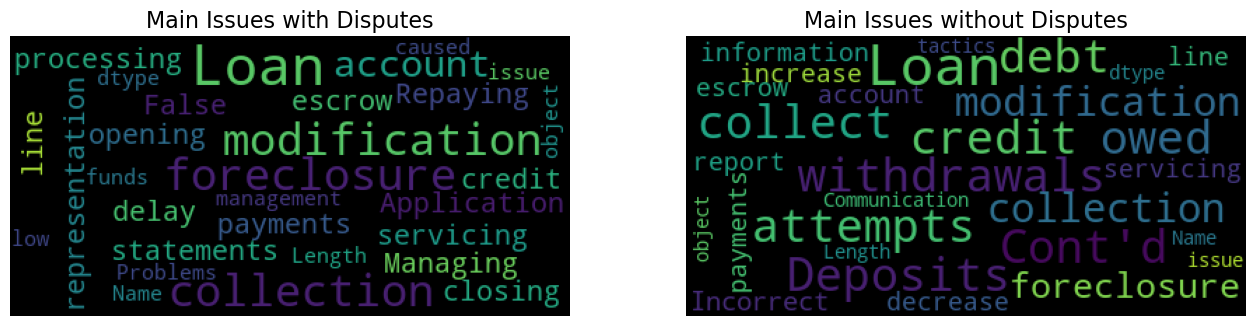

In [59]:
# Time for implementing word cloud
stopwords = set(STOPWORDS)

# Main Issue in Disputes
disputes_issue = df['issue'].loc[df['consumer_disputed?'] == 'Yes']


disputed_wordcloud = WordCloud(
    background_color='black',
    stopwords=stopwords,
    max_words=200,
    max_font_size=40, 
    random_state=42
    ).generate(str(df['issue'].loc[df['consumer_disputed?'] == 'Yes'])
)

nodispute_wordcloud = WordCloud(
    background_color='black',
    stopwords=stopwords,
    max_words=200,
    max_font_size=40, 
    random_state=42
    ).generate(str(df['issue'].loc[df['consumer_disputed?'] == 'No'])
)

# Issue wordclouds with and without disputes subplots
fig = plt.figure(figsize=(16,8))
fig.add_subplot(221)
plt.imshow(disputed_wordcloud)
plt.title('Main Issues with Disputes', fontsize=16)
plt.axis('off')

fig.add_subplot(222)
plt.imshow(nodispute_wordcloud)
plt.title('Main Issues without Disputes', fontsize=16)
plt.axis('off')
plt.show()

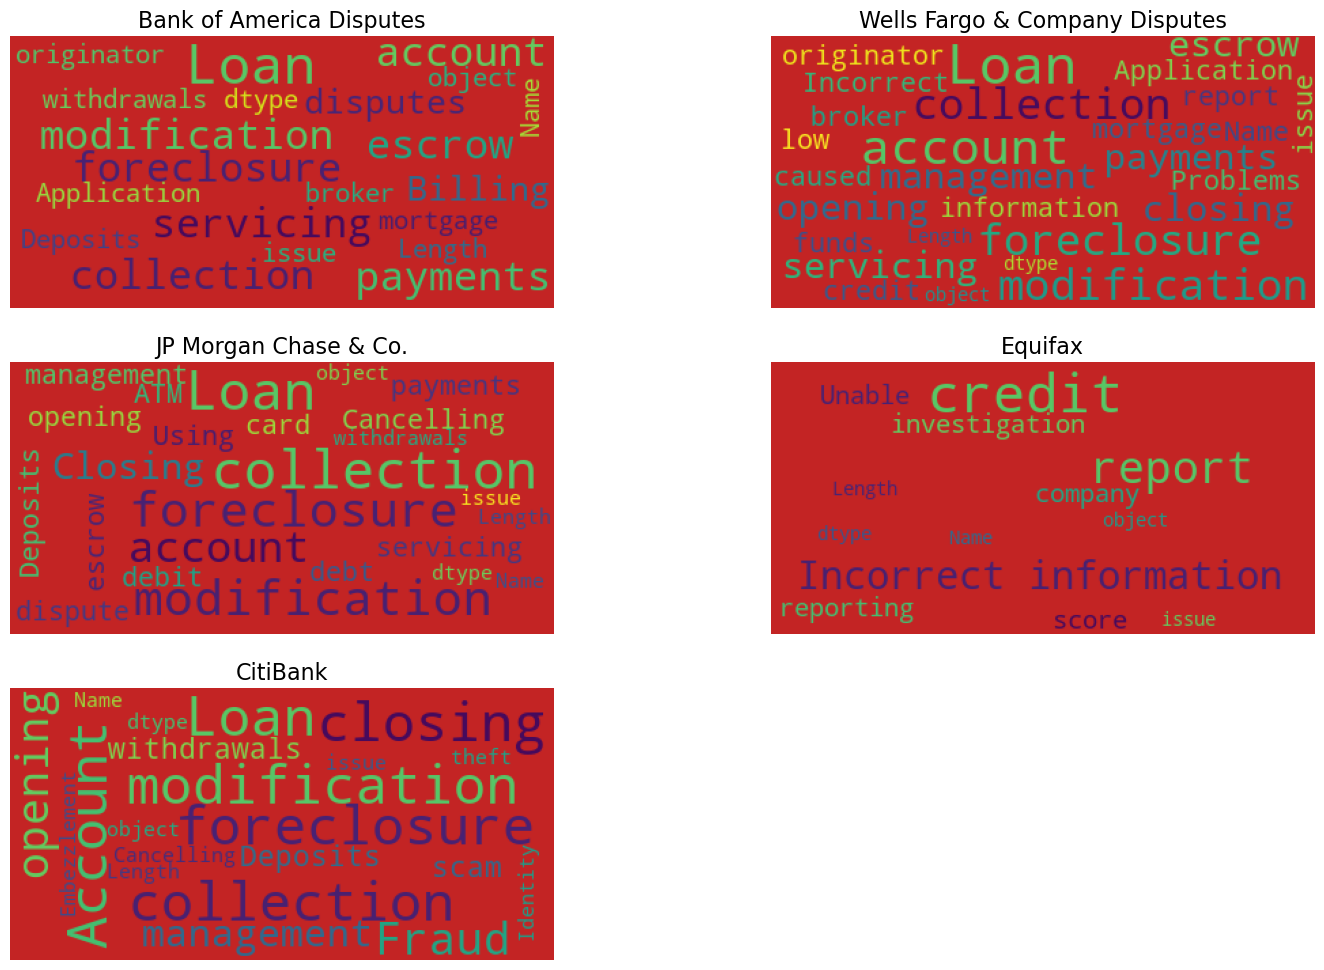

In [62]:
boa_dis = df['issue'].loc[(df['consumer_disputed?'] == 'Yes') & (df['company'] == "Bank of America")]
wfc_dis = df['issue'].loc[(df['consumer_disputed?'] == 'Yes') & (df['company'] == "Wells Fargo & Company")]
jpm_dis = df['issue'].loc[(df['consumer_disputed?'] == 'Yes') & (df['company'] == "JPMorgan Chase & Co.")] 
equi_dis = df['issue'].loc[(df['consumer_disputed?'] == 'Yes') & (df['company'] == "Equifax")]
citi_dis = df['issue'].loc[(df['consumer_disputed?'] == 'Yes') & (df['company'] == "Citibank")]


# Create Subplots of Wordclouds
fig = plt.figure(figsize=(18,12))

# First Subplot
plt.subplot(3, 2, 1)
boa_disputed_wordcloud = WordCloud(
    background_color='rgb(195, 36, 36)',
    stopwords=stopwords,
    max_words=500,
    max_font_size=40, 
    random_state=42
    ).generate(str(boa_dis)
)

plt.imshow(boa_disputed_wordcloud)
plt.title('Bank of America Disputes', fontsize=16)
plt.axis('off')

# Second Subplot
plt.subplot(3, 2, 2)
wfc_disputed_wordcloud = WordCloud(
    background_color='rgb(195, 36, 36)',
    stopwords=stopwords,
    max_words=500,
    max_font_size=40, 
    random_state=42
    ).generate(str(wfc_dis)
)

plt.imshow(wfc_disputed_wordcloud)
plt.title('Wells Fargo & Company Disputes', fontsize=16)
plt.axis('off')

plt.subplot(3, 2, 3)
jpm_disputed_wordcloud = WordCloud(
    background_color='rgb(195, 36, 36)',
    stopwords=stopwords,
    max_words=500,
    max_font_size=40, 
    random_state=42
    ).generate(str(jpm_dis)
)

plt.imshow(jpm_disputed_wordcloud)
plt.title('JP Morgan Chase & Co.', fontsize=16)
plt.axis('off')


plt.subplot(3, 2, 4)
equi_disputed_wordcloud = WordCloud(
    background_color='rgb(195, 36, 36)',
    stopwords=stopwords,
    max_words=500,
    max_font_size=40, 
    random_state=42
    ).generate(str(equi_dis)
)

plt.imshow(equi_disputed_wordcloud)
plt.title('Equifax', fontsize=16)
plt.axis('off')

plt.subplot(3, 2, 5)
citi_disputed_wordcloud = WordCloud(
    background_color='rgb(195, 36, 36)',
    stopwords=stopwords,
    max_words=500,
    max_font_size=40, 
    random_state=42
    ).generate(str(citi_dis)
)

plt.imshow(citi_disputed_wordcloud)
plt.title('CitiBank', fontsize=16)
plt.axis('off')

plt.show()

In [61]:
df.head()

,date_received,product,sub_product,issue,sub_issue,consumer_complaint_narrative,company_public_response,company,state,zipcode,tags,consumer_consent_provided,submitted_via,date_sent_to_company,company_response_to_consumer,timely_response,consumer_disputed?,complaint_id,year_received,month_received
0,2013-08-30,Mortgage,Other mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,U.S. Bancorp,CA,95993,NaN,NaN,Referral,09/03/2013,Closed with explanation,Yes,Yes,511074,2013,8
1,2013-08-30,Mortgage,Other mortgage,"Loan servicing, payments, escrow account",NaN,NaN,NaN,Wells Fargo & Company,CA,91104,NaN,NaN,Referral,09/03/2013,Closed with explanation,Yes,Yes,511080,2013,8
2,2013-08-30,Credit reporting,NaN,Incorrect information on credit report,Account status,NaN,NaN,Wells Fargo & Company,NY,11764,NaN,NaN,Postal mail,09/18/2013,Closed with explanation,Yes,No,510473,2013,8
3,2013-08-30,Student loan,Non-federal student loan,Repaying your loan,Repaying your loan,NaN,NaN,"Navient Solutions, Inc.",MD,21402,NaN,NaN,Email,08/30/2013,Closed with explanation,Yes,Yes,510326,2013,8
4,2013-08-30,Debt collection,Credit card,False statements or representation,Attempted to collect wrong amount,NaN,NaN,Resurgent Capital Services L.P.,GA,30106,NaN,NaN,Web,08/30/2013,Closed with explanation,Yes,Yes,511067,2013,8


In [63]:
dispute_presence = df.loc[df['consumer_disputed?'] == 'Yes']
cross_month = pd.crosstab(dispute_presence['state'], dispute_presence['company']).apply(lambda x: x/x.sum() * 100)

In [64]:
#  Share of Most disputes for Bank of America.
df_boa = pd.DataFrame(cross_month['Bank of America']).reset_index().sort_values(by="Bank of America", ascending=False).round(2)
df_boa = df_boa.rename(columns={'Bank of America': 'share of complaints'})

for col in df_boa.columns:
    df_boa[col] = df_boa[col].astype(str)
    
    
scl = [[0.0, 'rgb(202, 202, 202)'],[0.2, 'rgb(253, 205, 200)'],[0.4, 'rgb(252, 169, 161)'],
            [0.6, 'rgb(247, 121, 108  )'],[0.8, 'rgb(255, 39, 39)'],[1.0, 'rgb(219, 0, 0)']]


df_boa['text'] = "State Code: " + df_boa['state'] + '<br>'


data = [ dict(
        type='choropleth',
        colorscale = scl,
        autocolorscale = False,
        locations = df_boa['state'],
        z = df_boa['share of complaints'], 
        locationmode = 'USA-states',
        text = df_boa['text'],
        marker = dict(
            line = dict (
                color = 'rgb(255,255,255)',
                width = 2
            ) ),
        colorbar = dict(
            title = "%")
        ) ]

layout = dict(
    title = 'Most Complaints by State <br> Bank of America',
    geo = dict(
        scope = 'usa',
        projection=dict(type='albers usa'),
        showlakes = True,
        lakecolor = 'rgb(255, 255, 255)')
)

fig = dict(data=data, layout=layout)
iplot(fig, filename='d3-cloropleth-map')

In [65]:
df_wfc = pd.DataFrame(cross_month['Wells Fargo & Company']).reset_index().sort_values(by="Wells Fargo & Company", ascending=False).round(2)
df_wfc = df_wfc.rename(columns={'Wells Fargo & Company': 'share of complaints'})

for col in df_wfc.columns:
    df_wfc[col] = df_wfc[col].astype(str)
    
    
scl = [[0.0, 'rgb(202, 202, 202)'],[0.2, 'rgb(253, 205, 200)'],[0.4, 'rgb(252, 169, 161)'],
            [0.6, 'rgb(247, 121, 108  )'],[0.8, 'rgb(255, 39, 39)'],[1.0, 'rgb(219, 0, 0)']]


df_wfc['text'] = "State Code: " + df_wfc['state'] + '<br>'


data = [ dict(
        type='choropleth',
        colorscale = scl,
        autocolorscale = False,
        locations = df_wfc['state'],
        z = df_wfc['share of complaints'], 
        locationmode = 'USA-states',
        text = df_wfc['text'],
        marker = dict(
            line = dict (
                color = 'rgb(255,255,255)',
                width = 2
            ) ),
        colorbar = dict(
            title = "%")
        ) ]

layout = dict(
    title = 'Most Complaints by State <br> Wells Fargo & Company',
    geo = dict(
        scope = 'usa',
        projection=dict(type='albers usa'),
        showlakes = True,
        lakecolor = 'rgb(255, 255, 255)')
)

fig = dict(data=data, layout=layout)
iplot(fig, filename='d3-cloropleth-map')

In [66]:
df_jpm = pd.DataFrame(cross_month['JPMorgan Chase & Co.']).reset_index().sort_values(by="JPMorgan Chase & Co.", ascending=False).round(2)
df_jpm = df_jpm.rename(columns={'JPMorgan Chase & Co.': 'share of complaints'})

for col in df_jpm.columns:
    df_jpm[col] = df_jpm[col].astype(str)
    
    
scl = [[0.0, 'rgb(202, 202, 202)'],[0.2, 'rgb(253, 205, 200)'],[0.4, 'rgb(252, 169, 161)'],
            [0.6, 'rgb(247, 121, 108  )'],[0.8, 'rgb(255, 39, 39)'],[1.0, 'rgb(219, 0, 0)']]


df_jpm['text'] = "State Code: " + df_jpm['state'] + '<br>'


data = [ dict(
        type='choropleth',
        colorscale = scl,
        autocolorscale = False,
        locations = df_jpm['state'],
        z = df_jpm['share of complaints'], 
        locationmode = 'USA-states',
        text = df_jpm['text'],
        marker = dict(
            line = dict (
                color = 'rgb(255,255,255)',
                width = 2
            ) ),
        colorbar = dict(
            title = "%")
        ) ]

layout = dict(
    title = 'Most Complaints by State <br> JPMorgan Chase & Co.',
    geo = dict(
        scope = 'usa',
        projection=dict(type='albers usa'),
        showlakes = True,
        lakecolor = 'rgb(255, 255, 255)')
)

fig = dict(data=data, layout=layout)
iplot(fig, filename='d3-cloropleth-map')

In [67]:
df_eq = pd.DataFrame(cross_month["Equifax"]).reset_index().sort_values(by="Equifax", ascending=False).round(2)
df_eq = df_eq.rename(columns={'Equifax': 'share of complaints'})

for col in df_eq.columns:
    df_eq[col] = df_eq[col].astype(str)
    
    
scl = [[0.0, 'rgb(202, 202, 202)'],[0.2, 'rgb(253, 205, 200)'],[0.4, 'rgb(252, 169, 161)'],
            [0.6, 'rgb(247, 121, 108  )'],[0.8, 'rgb(255, 39, 39)'],[1.0, 'rgb(219, 0, 0)']]


df_eq['text'] = "State Code: " + df_eq['state'] + '<br>'


data = [ dict(
        type='choropleth',
        colorscale = scl,
        autocolorscale = False,
        locations = df_eq['state'],
        z = df_eq['share of complaints'], 
        locationmode = 'USA-states',
        text = df_eq['text'],
        marker = dict(
            line = dict (
                color = 'rgb(255,255,255)',
                width = 2
            ) ),
        colorbar = dict(
            title = "%")
        ) ]

layout = dict(
    title = 'Most Complaints by State <br> Equifax',
    geo = dict(
        scope = 'usa',
        projection=dict(type='albers usa'),
        showlakes = True,
        lakecolor = 'rgb(255, 255, 255)')
)

fig = dict(data=data, layout=layout)
iplot(fig, filename='d3-cloropleth-map')

In [68]:
df_citi = pd.DataFrame(cross_month["Citibank"]).reset_index().sort_values(by="Citibank", ascending=False).round(2)
df_citi = df_citi.rename(columns={'Citibank': 'share of complaints'})

for col in df_citi.columns:
    df_citi[col] = df_citi[col].astype(str)
    
    
scl = [[0.0, 'rgb(202, 202, 202)'],[0.2, 'rgb(253, 205, 200)'],[0.4, 'rgb(252, 169, 161)'],
            [0.6, 'rgb(247, 121, 108  )'],[0.8, 'rgb(255, 39, 39)'],[1.0, 'rgb(219, 0, 0)']]


df_citi['text'] = "State Code: " + df_citi['state'] + '<br>'


data = [ dict(
        type='choropleth',
        colorscale = scl,
        autocolorscale = False,
        locations = df_eq['state'],
        z = df_citi['share of complaints'], 
        locationmode = 'USA-states',
        text = df_citi['text'],
        marker = dict(
            line = dict (
                color = 'rgb(255,255,255)',
                width = 2
            ) ),
        colorbar = dict(
            title = "%")
        ) ]

layout = dict(
    title = 'Most Complaints by State <br> CitiBank',
    geo = dict(
        scope = 'usa',
        projection=dict(type='albers usa'),
        showlakes = True,
        lakecolor = 'rgb(255, 255, 255)')
)

fig = dict(data=data, layout=layout)
iplot(fig, filename='d3-cloropleth-map')